<a href="https://colab.research.google.com/github/OJB-Quantum/Notebooks-for-Ideas/blob/main/Eigenmode_Analysis_GDSTK_Fractals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install triangle gdstk shapely scikit-fem matplotlib --no-deps

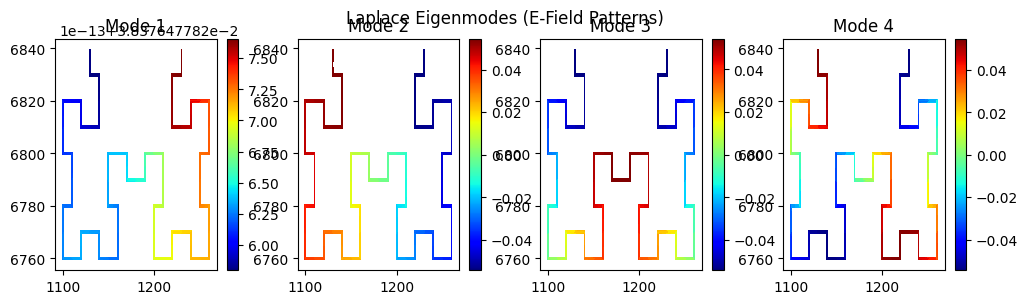

In [24]:
import gdstk
import numpy as np

# Parameters
iteration = 22
line_width = 1.0  # in microns
step = 10.0  # step size in microns

def generate_fibonacci_word(n):
    a, b = "0", "01"
    for _ in range(n - 1):
        a, b = b, b + a
    return b

fib_word = generate_fibonacci_word(iteration)
directions = [np.array([1, 0]), np.array([0, 1]), np.array([-1, 0]), np.array([0, -1])]
current_pos = np.array([0.0, 0.0])
direction = 0  # Start facing right
points = [tuple(current_pos)]

for idx, char in enumerate(fib_word):
    if char == '1':
        current_pos += directions[direction] * step
    else:
        if idx % 2 == 0:
            direction = (direction + 1) % 4
        else:
            direction = (direction - 1) % 4
        current_pos += directions[direction] * step
    points.append(tuple(current_pos))

path = gdstk.FlexPath(points, line_width)
cell = gdstk.Cell("FIBONACCI_FRACTAL")
cell.add(path)
lib = gdstk.Library()
lib.add(cell)
lib.write_gds("dense_fibonacci_fractal.gds")

####

import gdstk
import numpy as np
from shapely.geometry import Polygon
from skfem import MeshTri, Basis, ElementTriP2
import matplotlib.pyplot as plt
from skfem.assembly import asm
from skfem.models.poisson import laplace, mass
from scipy.sparse.linalg import eigsh
from skfem.visuals.matplotlib import plot
import triangle as tr

# Read GDS
lib = gdstk.read_gds("dense_fibonacci_fractal.gds")
cell = lib.top_level()[0]

# Extract all polygons
polygons = [poly.points for poly in cell.polygons]
areas = [Polygon(np.asarray(p)).area for p in polygons]
main_poly_points = polygons[np.argmax(areas)]

poly = Polygon(main_poly_points)

# Triangulate: provide both vertices and segments
exterior = np.array(poly.exterior.coords)
vertices = exterior[:-1]  # Remove duplicate endpoint
segments = np.column_stack([np.arange(len(vertices)), np.roll(np.arange(len(vertices)), -1)])
A = dict(vertices=vertices, segments=segments)
B = tr.triangulate(A, 'p')
mesh = MeshTri(B['vertices'].T, B['triangles'].T)

# Use quadratic finite elements for accuracy
basis = Basis(mesh, ElementTriP2())

A_mat = asm(laplace, basis)
M_mat = asm(mass, basis)

num_modes = 4
vals, vecs = eigsh(A_mat, k=num_modes, M=M_mat, sigma=0, which='LM')

fig, axs = plt.subplots(1, num_modes, figsize=(12, 3))
for i in range(num_modes):
    plot(basis, vecs[:, i], ax=axs[i], colorbar=True)
    axs[i].set_title(f"Mode {i+1}")
plt.suptitle("Laplace Eigenmodes (E-Field Patterns)")
plt.show()


<ipython-input-26-2131fdd144d9>:31: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if domain.type == 'Polygon':
<ipython-input-26-2131fdd144d9>:33: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  elif domain.type == 'MultiPolygon':


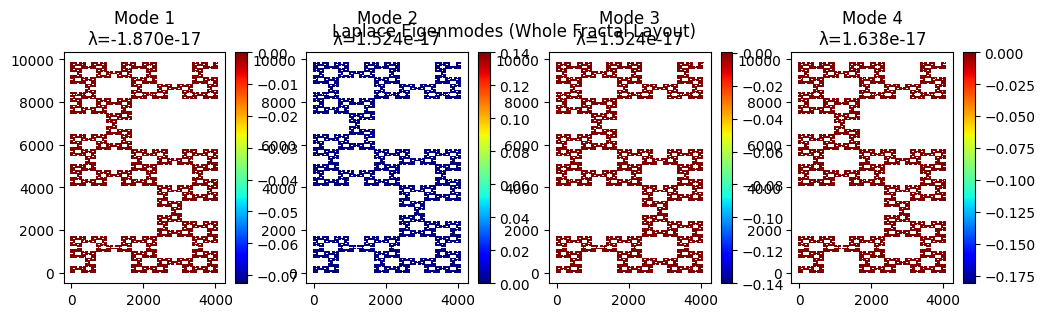

In [26]:
import gdstk
import numpy as np
from shapely.geometry import Polygon
from shapely.ops import unary_union
from skfem import MeshTri, Basis, ElementTriP2
import matplotlib.pyplot as plt
from skfem.assembly import asm
from skfem.models.poisson import laplace, mass
from scipy.sparse.linalg import eigsh
from skfem.visuals.matplotlib import plot
import triangle as tr

# ---- 1. Load your GDS ----
lib = gdstk.read_gds("dense_fibonacci_fractal.gds")
cell = lib.top_level()[0]

# ---- 2. Extract all polygons and form their union ----
poly_list = []
for pts in cell.polygons:
    # Fix possible format issues
    arr = np.array(pts.points) if hasattr(pts, 'points') else np.array(pts)
    if arr.shape[0] >= 3:  # must be at least a triangle
        poly = Polygon(arr)
        if poly.is_valid and not poly.is_empty:
            poly_list.append(poly)

if len(poly_list) == 0:
    raise ValueError("No valid polygons found in the GDS cell.")

domain = unary_union(poly_list)
if domain.type == 'Polygon':
    polygons_for_meshing = [domain]
elif domain.type == 'MultiPolygon':
    polygons_for_meshing = list(domain.geoms)
else:
    raise ValueError(f"Unsupported domain type: {domain.type}")

# ---- 3. Triangulate the union geometry ----
# For complex shapes, merge all exteriors and all holes
vertices = []
segments = []
vertex_offset = 0

for poly in polygons_for_meshing:
    ext = np.array(poly.exterior.coords)
    n_ext = len(ext) - 1  # last point duplicates the first
    vertices.extend(ext[:-1])
    segments.extend([[i + vertex_offset, (i + 1) % n_ext + vertex_offset] for i in range(n_ext)])
    vertex_offset += n_ext

    # Add any holes
    for hole in poly.interiors:
        hole_coords = np.array(hole.coords)
        n_hole = len(hole_coords) - 1
        vertices.extend(hole_coords[:-1])
        segments.extend([[i + vertex_offset, (i + 1) % n_hole + vertex_offset] for i in range(n_hole)])
        vertex_offset += n_hole

vertices = np.array(vertices)
segments = np.array(segments)

A = dict(vertices=vertices, segments=segments)
# You can specify 'max_area' here if meshing is too dense or coarse, e.g. 'pqa0.5'
B = tr.triangulate(A, 'p')

# ---- 4. Build the mesh and solve eigenmodes ----
mesh = MeshTri(B['vertices'].T, B['triangles'].T)
basis = Basis(mesh, ElementTriP2())

A_mat = asm(laplace, basis)
M_mat = asm(mass, basis)

num_modes = 4  # Show the first 4 eigenmodes
vals, vecs = eigsh(A_mat, k=num_modes, M=M_mat, sigma=0, which='LM')

# ---- 5. Plot the eigenmodes ----
fig, axs = plt.subplots(1, num_modes, figsize=(12, 3))
for i in range(num_modes):
    plot(basis, vecs[:, i], ax=axs[i], colorbar=True)
    axs[i].set_title(f"Mode {i+1}\nλ={vals[i]:.3e}")
plt.suptitle("Laplace Eigenmodes (Whole Fractal Layout)")
plt.tight_layout()
plt.show()

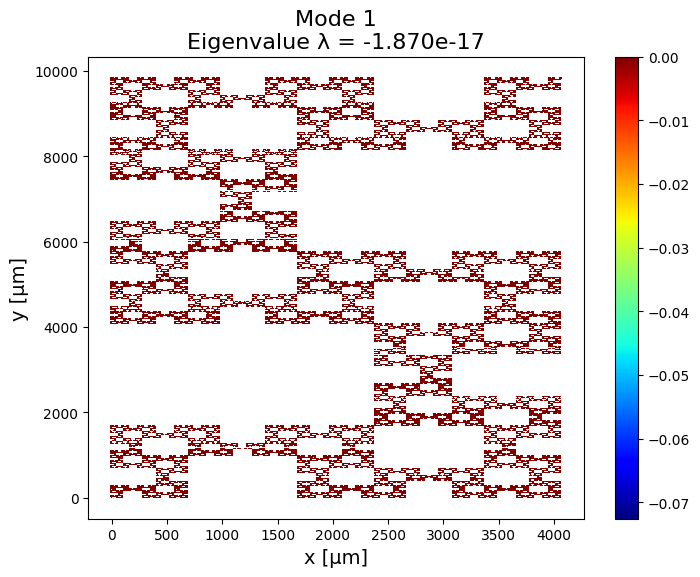

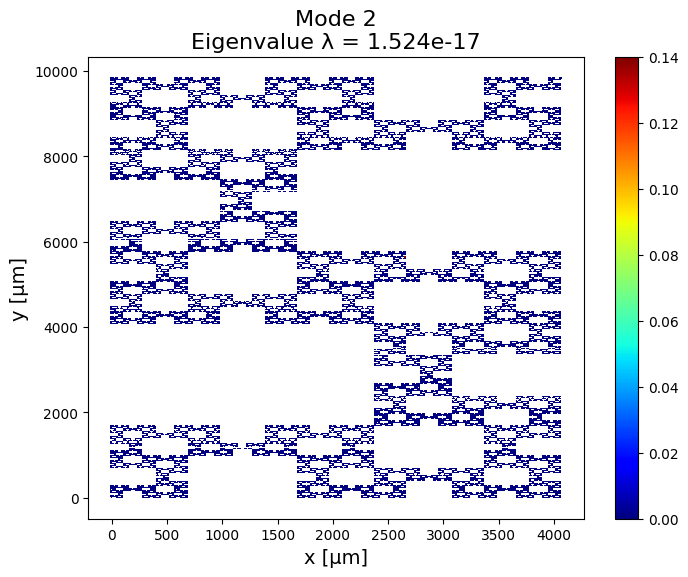

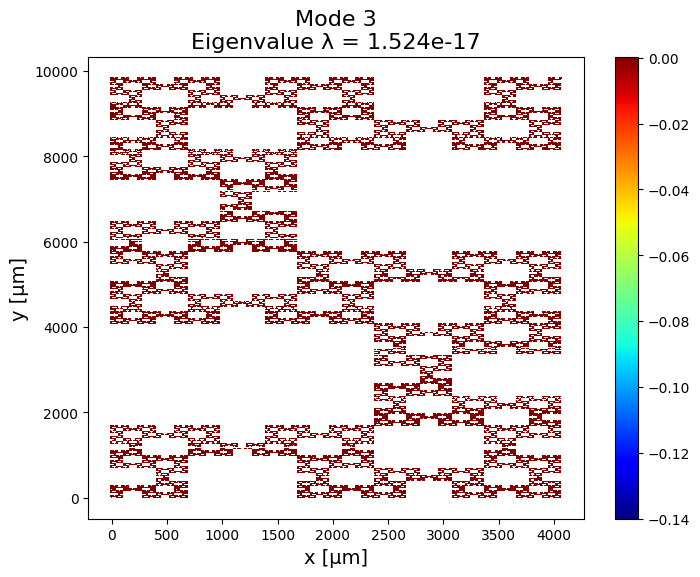

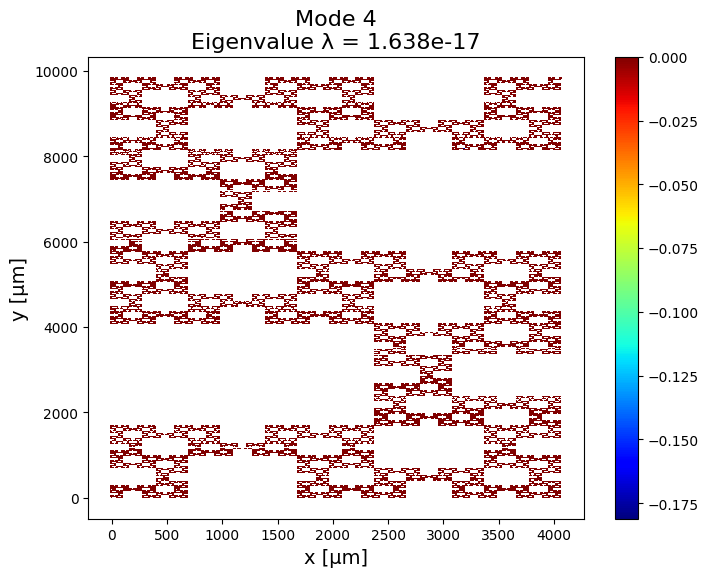

In [27]:
# ---- 5. Plot the eigenmodes as full-sized separate figures ----
import matplotlib.pyplot as plt

for i in range(num_modes):
    fig, ax = plt.subplots(figsize=(8, 6))  # Large figure size
    plot(basis, vecs[:, i], ax=ax, colorbar=True)
    ax.set_title(f"Mode {i+1}\nEigenvalue λ = {vals[i]:.3e}", fontsize=16)
    ax.set_xlabel('x [μm]', fontsize=14)
    ax.set_ylabel('y [μm]', fontsize=14)
    plt.show()


<ipython-input-50-e9941b36199e>:33: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if domain.type == 'Polygon':
<ipython-input-50-e9941b36199e>:35: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  elif domain.type == 'MultiPolygon':


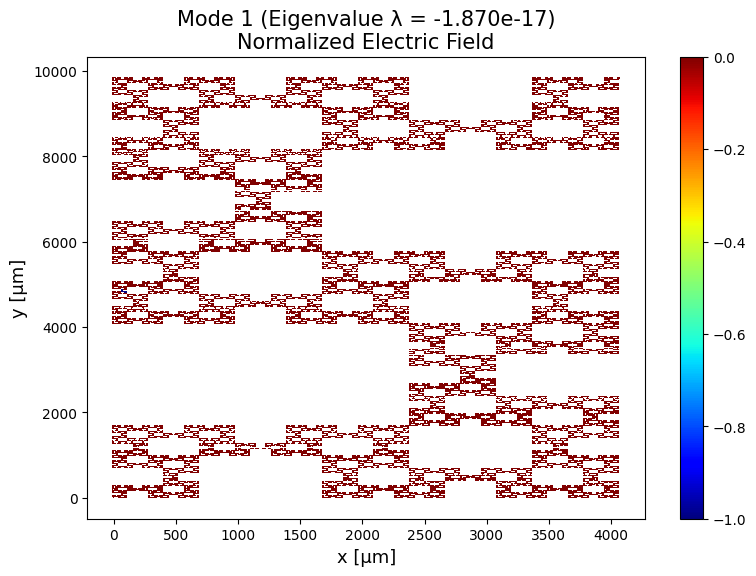

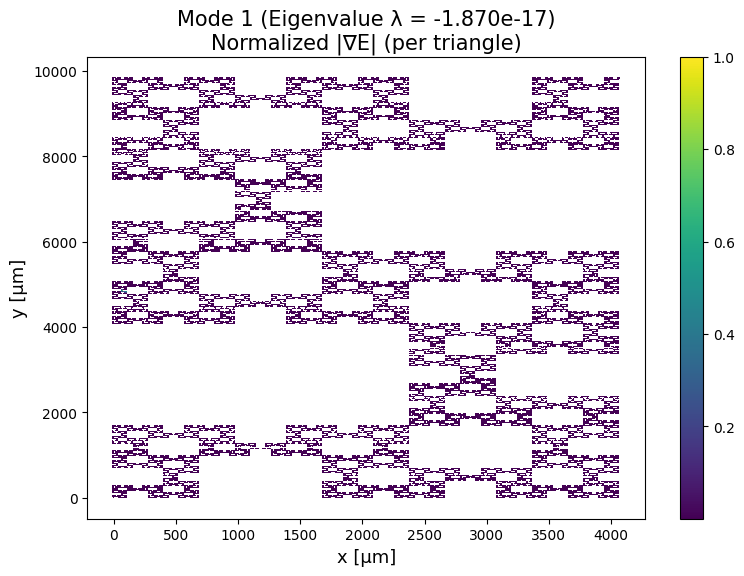

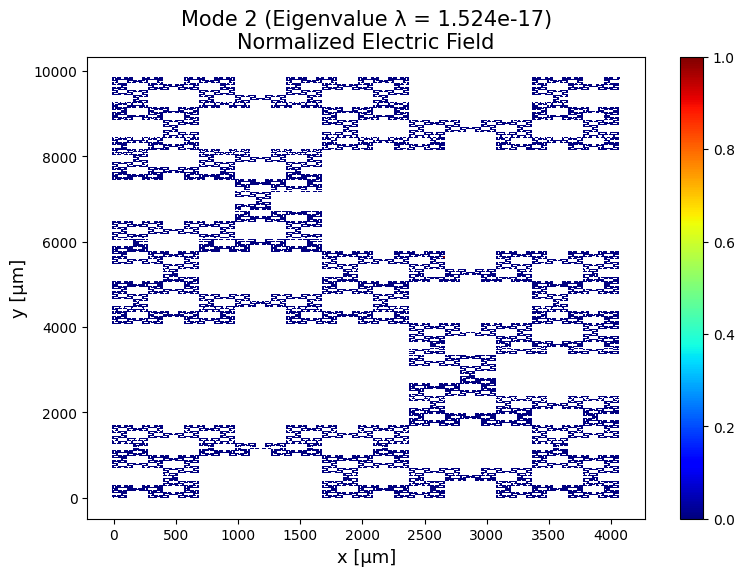

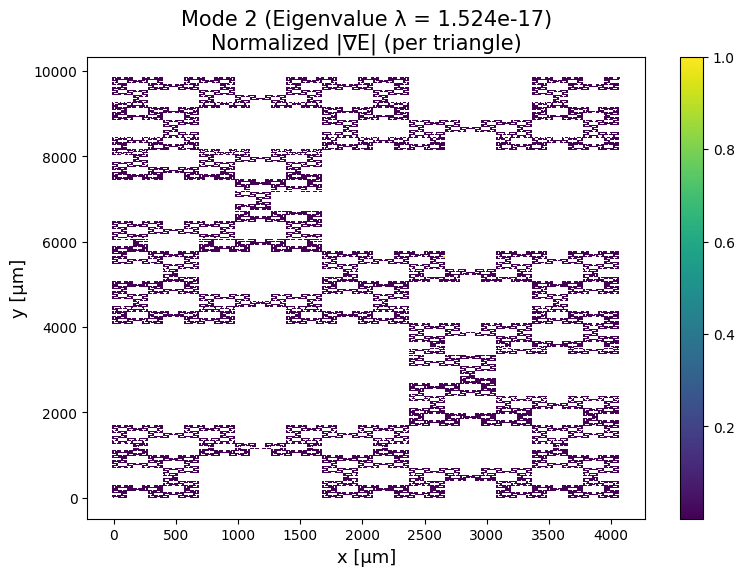

In [50]:
# 2. Import modules
import gdstk
import numpy as np
from shapely.geometry import Polygon
from shapely.ops import unary_union
from skfem import MeshTri, Basis, ElementTriP2
import matplotlib.pyplot as plt
from skfem.assembly import asm
from skfem.models.poisson import laplace, mass
from scipy.sparse.linalg import eigsh
from skfem.visuals.matplotlib import plot
from skfem.helpers import grad
from skfem import ElementTriP1
import triangle as tr
import matplotlib.tri as mtri


# 3. Read GDS and build the full union of all polygons
lib = gdstk.read_gds("dense_fibonacci_fractal.gds")
cell = lib.top_level()[0]

poly_list = []
for pts in cell.polygons:
    arr = np.array(pts.points) if hasattr(pts, 'points') else np.array(pts)
    if arr.shape[0] >= 3:
        poly = Polygon(arr)
        if poly.is_valid and not poly.is_empty:
            poly_list.append(poly)
if len(poly_list) == 0:
    raise ValueError("No valid polygons found in the GDS cell.")

domain = unary_union(poly_list)
if domain.type == 'Polygon':
    polygons_for_meshing = [domain]
elif domain.type == 'MultiPolygon':
    polygons_for_meshing = list(domain.geoms)
else:
    raise ValueError(f"Unsupported domain type: {domain.type}")

# 4. Prepare vertices and segments for triangulation
vertices = []
segments = []
vertex_offset = 0
for poly in polygons_for_meshing:
    ext = np.array(poly.exterior.coords)
    n_ext = len(ext) - 1
    vertices.extend(ext[:-1])
    segments.extend([[i + vertex_offset, (i + 1) % n_ext + vertex_offset] for i in range(n_ext)])
    vertex_offset += n_ext
    for hole in poly.interiors:
        hole_coords = np.array(hole.coords)
        n_hole = len(hole_coords) - 1
        vertices.extend(hole_coords[:-1])
        segments.extend([[i + vertex_offset, (i + 1) % n_hole + vertex_offset] for i in range(n_hole)])
        vertex_offset += n_hole
vertices = np.array(vertices)
segments = np.array(segments)
A = dict(vertices=vertices, segments=segments)
B = tr.triangulate(A, 'p')

# 5. Build mesh and solve eigenmodes
mesh = MeshTri(B['vertices'].T, B['triangles'].T)
basis = Basis(mesh, ElementTriP2())
A_mat = asm(laplace, basis)
M_mat = asm(mass, basis)
num_modes = 4
vals, vecs = eigsh(A_mat, k=num_modes, M=M_mat, sigma=0, which='LM')

# 6. Compute and plot normalized electric and "magnetic" fields for first and second modes
def compute_E_B_fields(basis, mode_vector):
    interp = basis.interpolate(mode_vector)
    E_norm = interp.value / np.max(np.abs(interp.value))
    gradE = interp.grad   # shape (2, N)
    B_norm = np.linalg.norm(gradE, axis=0)
    B_norm /= np.max(np.abs(B_norm))
    return E_norm, B_norm

from skfem import ElementTriP1, Basis

for i in [0, 1]:
    # --- Plot normalized electric field at mesh nodes (standard plot) ---
    fig, ax = plt.subplots(figsize=(9, 6))
    plot(basis, vecs[:, i] / np.max(np.abs(vecs[:, i])), ax=ax, colorbar=True)
    ax.set_title(f"Mode {i+1} (Eigenvalue λ = {vals[i]:.3e})\nNormalized Electric Field", fontsize=15)
    ax.set_xlabel('x [μm]', fontsize=13)
    ax.set_ylabel('y [μm]', fontsize=13)
    plt.show()

    # --- Compute |∇E| per triangle manually ---
    p = mesh.p   # shape (2, n_nodes)
    t = mesh.t   # shape (3, n_triangles)
    E = vecs[:, i]

    grads = []
    for tri in t.T:
        x1, y1 = p[:, tri[0]]
        x2, y2 = p[:, tri[1]]
        x3, y3 = p[:, tri[2]]
        E1, E2, E3 = E[tri[0]], E[tri[1]], E[tri[2]]

        # Set up the system: [ [x1 y1 1], [x2 y2 1], [x3 y3 1] ] * [a, b, c] = [E1, E2, E3]
        A = np.array([
            [x1, y1, 1],
            [x2, y2, 1],
            [x3, y3, 1],
        ])
        b_vec = np.array([E1, E2, E3])
        # Solve for a, b, c in E(x, y) = a*x + b*y + c
        sol = np.linalg.solve(A, b_vec)
        gradx, grady = sol[0], sol[1]
        grads.append([gradx, grady])

    grads = np.array(grads)  # shape (n_triangles, 2)
    B_norm_elems = np.linalg.norm(grads, axis=1)
    B_norm_elems /= np.max(B_norm_elems)

    # --- Plot |∇E| at triangle centers using tripcolor ---
    xnodes = mesh.p[0]
    ynodes = mesh.p[1]
    triangles = mesh.t.T

    fig, ax = plt.subplots(figsize=(9, 6))
    tpc = ax.tripcolor(xnodes, ynodes, triangles, facecolors=B_norm_elems, shading='flat')
    fig.colorbar(tpc, ax=ax)
    ax.set_title(f"Mode {i+1} (Eigenvalue λ = {vals[i]:.3e})\nNormalized |∇E| (per triangle)", fontsize=15)
    ax.set_xlabel('x [μm]', fontsize=13)
    ax.set_ylabel('y [μm]', fontsize=13)
    plt.show()
